# <span style="color:red"> Numerical Simulation Laboratory</span>
## <span style="color:orange">  Numerical exercises 7: Samuele Voltan's notebook.</span>

In [1]:
# LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
import scipy.constants

In [2]:
# FUNCTIONS
def error(AV, AV2, n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2 - AV*AV)/n)

def block_method(data): # Function for blocking method data analysis
    sum_prog = 0.
    sum2_prog = 0.
    y = np.zeros((len(data), 2))
    for i in range(len(data)):
        sum_prog = sum_prog + data[i]
        sum2_prog = sum2_prog + data[i]*data[i]
        AV = sum_prog / (i+1)
        AV2 = sum2_prog / (i+1)
        y[i,0] = AV
        y[i,1] = error(AV, AV2, i)
    return y

def autocorrelation(x):
    chi = np.zeros(x.shape)
    den = np.var(x)
    for i in range(len(x)):
        num = np.sum(x[:len(x)-i]*x[i:]) - np.sum(x[:len(x)-i]) * np.sum(x[i:]) / (len(x) - i)
        num = num / (len(x) - i)
        chi[i] = num / den
    return chi

def exp_fit(t, x):
    return np.exp(- t/x)

In [3]:
# DATA FILES
data3_solid = np.loadtxt("data/lab07/ex07.3/ex07.3_solid.out")
data3_liquid = np.loadtxt("data/lab07/ex07.3/ex07.3_liquid.out")
data3_gas = np.loadtxt("data/lab07/ex07.3/ex07.3_gas.out")
data1 = np.loadtxt("data/lab07/ex07.1/ex07.1.out")
data1_big = np.loadtxt("data/lab07/ex07.1/ex07.1_big.out")
data4_solid_NVE = np.loadtxt("data/lab07/ex07.4/NVE_solid.out")
data4_liquid_NVE = np.loadtxt("data/lab07/ex07.4/NVE_liquid.out")
data4_gas_NVE = np.loadtxt("data/lab07/ex07.4/NVE_gas.out")
data4_solid_NVT = np.loadtxt("data/lab07/ex07.4/NVT_solid.out")
data4_liquid_NVT = np.loadtxt("data/lab07/ex07.4/NVT_liquid.out")
data4_gas_NVT = np.loadtxt("data/lab07/ex07.4/NVT_gas.out")

### <span style="color:red"> Exercise 07.1

Use the Monte Carlo NVT code we have provided to print out instantaneous values of potential energy per particle, $U/N$, and pressure, $P$, along equilibrated Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ and $P$ to approximately estimate how large the blocks in your simulations should be. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red"> Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### <span style="color:orange"> Solution


I plot autocorrelation for the three phases using 10000 steps.

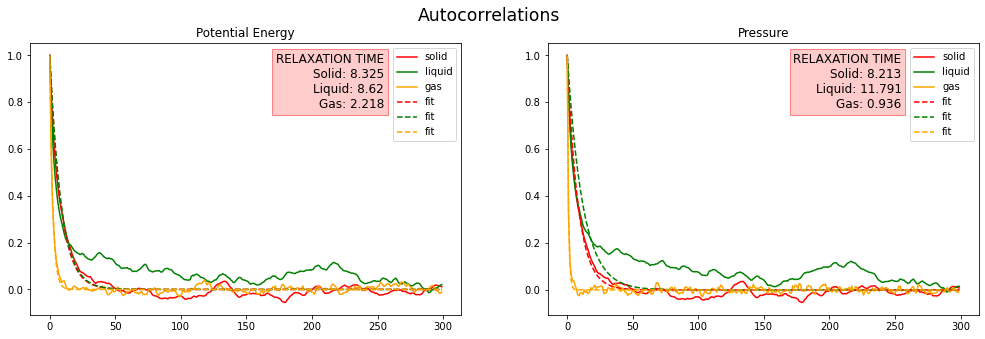

In [4]:
N_steps = 10000
title = ["Potential Energy", "Pressure"]
p = [0, 0, 0]
N_max = 300
x = np.arange(N_max)
plt.figure(figsize=(17,5))
plt.suptitle("Autocorrelations", fontsize = "xx-large")
for i in range(2) :
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    solid = autocorrelation(data1[:N_steps,i])
    liquid = autocorrelation(data1[N_steps: 2*N_steps,i])
    gas = autocorrelation(data1[2*N_steps:,i])
    plt.plot(solid[:N_max],'r-', label='solid')
    plt.plot(liquid[:N_max],'g-', label='liquid')
    plt.plot(gas[:N_max], color = 'orange', label='gas')
    # Solid
    popt, pcov = curve_fit(exp_fit, x, solid[:N_max])
    plt.plot(x, exp_fit(x,1 *popt), 'r-', linestyle='dashed', label="fit")
    p[0] = str(round(popt[0],3))
    # Liquid
    popt, pcov = curve_fit(exp_fit, x, liquid[:N_max])
    plt.plot(x, exp_fit(x,1 *popt), 'g-', linestyle='dashed', label="fit")
    p[1] = str(round(popt[0],3))
    # Gas
    popt, pcov = curve_fit(exp_fit, x, gas[:N_max])
    plt.plot(x, exp_fit(x,1 *popt), color = 'orange', linestyle='dashed', label="fit")
    p[2] = str(round(popt[0],3))
    plt.legend()
    plt.text(255, 1.01, r'RELAXATION TIME'+'\n'+r'Solid: '+p[0]+'\n'+ r'Liquid: '+p[1]+'\n'+r'Gas: '+p[2], size = 12,
             ha="right", va="top",
             bbox=dict(boxstyle="square",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    )
             )  
#    plt.xscale('log')
#    plt.yscale('log')

The fit parameters show what one could have already seen by looking at the plots: the gas phase is the first to become uncorrelated, while the solid and the liquid ones are slower. All three phases become uncorrelated after about 300 throws. Had we used more steps, the curves would have been much more smooth of course, but at this point there is no need to do that, since we can already be confident about the number of throws needed.

I show how the statistical error varies depending on the number of throws per block.

In [5]:
N_points = 500
error_solid_U = np.zeros(N_points)
error_solid_P = np.zeros(N_points)
error_liquid_U = np.zeros(N_points)
error_liquid_P = np.zeros(N_points)
error_gas_U = np.zeros(N_points)
error_gas_P = np.zeros(N_points)
for tpb in range(10, 5010, 10):
    stop = N_steps//tpb * tpb
    error_solid_U[tpb//10-1] = block_method(np.mean(data1_big[:stop,0].reshape(-1, tpb), axis=-1))[-1, 1]
    error_solid_P[tpb//10-1] = block_method(np.mean(data1_big[:stop,1].reshape(-1, tpb), axis=-1))[-1, 1]
    error_liquid_U[tpb//10-1] = block_method(np.mean(data1_big[N_steps:N_steps+stop,0].reshape(-1, tpb), axis=-1))[-1, 1]
    error_liquid_P[tpb//10-1] = block_method(np.mean(data1_big[N_steps:N_steps+stop,1].reshape(-1, tpb), axis=-1))[-1, 1]
    error_gas_U[tpb//10-1] = block_method(np.mean(data1_big[2*N_steps:2*N_steps+stop,0].reshape(-1, tpb), axis=-1))[-1, 1]
    error_gas_P[tpb//10-1] = block_method(np.mean(data1_big[2*N_steps:2*N_steps+stop,1].reshape(-1, tpb), axis=-1))[-1, 1]

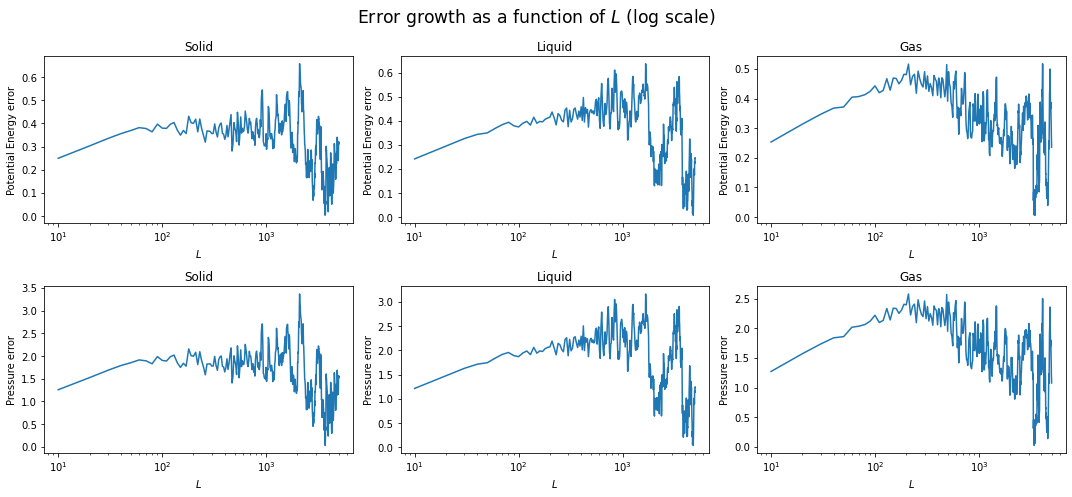

In [6]:
plt.figure(figsize=(15,7))
plt.suptitle("Error growth as a function of $L$ (log scale)", fontsize = "xx-large")

# Potential Energy
plt.subplot(2,3,1)
plt.title("Solid")
plt.plot(range(10, 5010, 10), error_solid_U);
plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Potential Energy error")
plt.subplot(2,3,2)
plt.title("Liquid")
plt.plot(range(10, 5010, 10), error_liquid_U);
plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Potential Energy error")
plt.subplot(2,3,3)
plt.title("Gas")
plt.plot(range(10, 5010, 10), error_gas_U);
plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Potential Energy error")

# Pressure
plt.subplot(2,3,4)
plt.title("Solid")
plt.plot(range(10, 5010, 10), error_solid_P, label = "Solid");
plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Pressure error")
plt.subplot(2,3,5)
plt.title("Liquid")
plt.plot(range(10, 5010, 10), error_liquid_P, label = "Liquid");
plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Pressure error")
plt.subplot(2,3,6)
plt.title("Gas")
plt.plot(range(10, 5010, 10), error_gas_P, label = "Gas");
plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Pressure error")

plt.tight_layout()
plt.plot();

Since what is required in Exercise 07.2 will be put to use in Exercise 07.4, I do not show any data here.

### <span style="color:red">Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, inside the previously used Molecular Dynamics code</span>.

### <span style="color:orange">Solution

I updated the <code>NVE.cpp</code> code and ran **one start and one measure step, without any equilibrations**. This produced the following output.

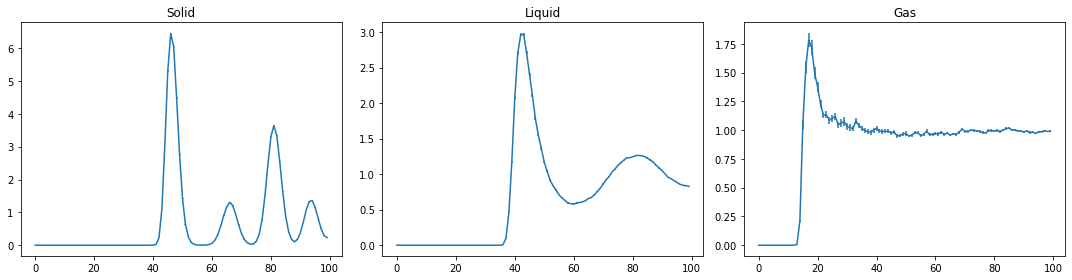

In [7]:
x = np.arange(100)
g_solid = []
g_liquid = []
g_gas = []
fig=plt.figure(figsize=(15, 4))
for i in range(100):
    g_solid.append(block_method(data3_solid[:, i+4]))
    g_liquid.append(block_method(data3_liquid[:, i+4]))
    g_gas.append(block_method(data3_gas[:, i+4]))
g_solid = np.array(g_solid)
g_liquid = np.array(g_liquid)
g_gas = np.array(g_gas)

plt.subplot(1,3,1)
plt.title("Solid")
plt.errorbar(x, g_solid[:, -1, 0], yerr = g_solid[:, -1, 1], ls="-");
plt.subplot(1,3,2)
plt.title("Liquid")
plt.errorbar(x, g_liquid[:, -1, 0], yerr = g_liquid[:, -1, 1], ls="-");
plt.subplot(1,3,3)
plt.title("Gas")
plt.errorbar(x, g_gas[:, -1, 0], yerr = g_gas[:, -1, 1], ls="-");
plt.plot()
plt.tight_layout()

The issues with the gas phase may be due to the number of blocks (only 10) and the fact that there is no equilibration process.

### <span style="color:red">Exercise 07.4

By means of your upgraded MC code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in SI units and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

### <span style="color:orange">Solution
Here I show the updated codes.

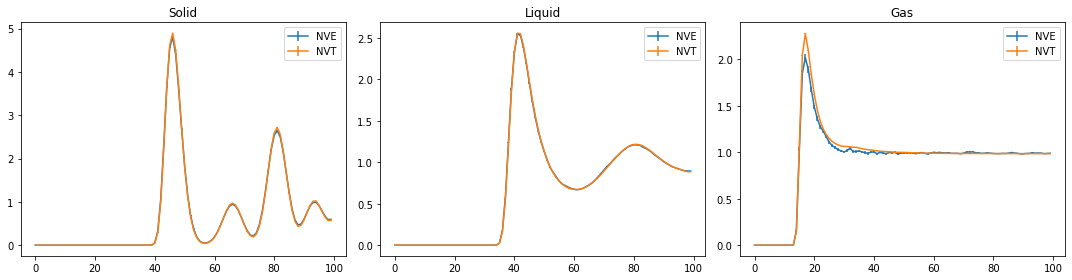

In [8]:
x = np.arange(100)
g_solid_NVE = []
g_liquid_NVE = []
g_gas_NVE = []
g_solid_NVT = []
g_liquid_NVT = []
g_gas_NVT = []
fig=plt.figure(figsize=(15, 4))
for i in range(100):
    g_solid_NVE.append(block_method(data4_solid_NVE[:, i+4]))
    g_liquid_NVE.append(block_method(data4_liquid_NVE[:, i+4]))
    g_gas_NVE.append(block_method(data4_gas_NVE[:, i+4]))
    g_solid_NVT.append(block_method(data4_solid_NVT[:, i+2]))
    g_liquid_NVT.append(block_method(data4_liquid_NVT[:, i+2]))
    g_gas_NVT.append(block_method(data4_gas_NVT[:, i+2]))

g_solid_NVE = np.array(g_solid_NVE)
g_liquid_NVE = np.array(g_liquid_NVE)
g_gas_NVE = np.array(g_gas_NVE)
g_solid_NVT = np.array(g_solid_NVT)
g_liquid_NVT = np.array(g_liquid_NVT)
g_gas_NVT = np.array(g_gas_NVT)

plt.subplot(1,3,1)
plt.title("Solid")
plt.errorbar(x, g_solid_NVE[:, -1, 0], yerr = g_solid_NVE[:, -1, 1], ls="-", label="NVE");
plt.errorbar(x, g_solid_NVT[:, -1, 0], yerr = g_solid_NVT[:, -1, 1], ls="-", label="NVT");
plt.legend()
plt.subplot(1,3,2)
plt.title("Liquid")
plt.errorbar(x, g_liquid_NVE[:, -1, 0], yerr = g_liquid_NVE[:, -1, 1], ls="-", label="NVE");
plt.errorbar(x, g_liquid_NVT[:, -1, 0], yerr = g_liquid_NVT[:, -1, 1], ls="-", label="NVT");
plt.legend()
plt.subplot(1,3,3)
plt.title("Gas")
plt.errorbar(x, g_gas_NVE[:, -1, 0], yerr = g_gas_NVE[:, -1, 1], ls="-", label="NVE");
plt.errorbar(x, g_gas_NVT[:, -1, 0], yerr = g_gas_NVT[:, -1, 1], ls="-", label="NVT");
plt.legend()
plt.plot()
plt.tight_layout()

There is a good consistency between the NVT and the NVE methods of sampling the $g(r)$. Note that the issues with the NVE gas phase remain, although the plot has improved. One solution could be adding more throws per block, as I already did in Exercise04.

In [9]:
epsilonk = 120.
sigma = 0.34e-9
epsilon = epsilonk * scipy.constants.k
pr = epsilon / (sigma * sigma * sigma)

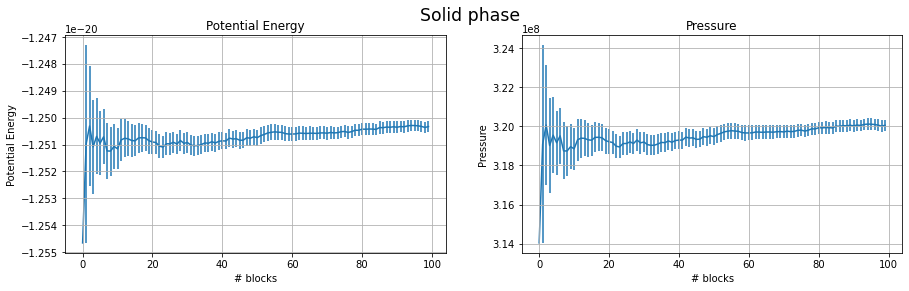

In [10]:
title = ["Potential Energy", "Pressure"]
value = [epsilon, pr]
x = np.arange(100)
plt.figure(figsize=(15,4))
plt.suptitle("Solid phase", fontsize = "xx-large")
for i in range(2) :
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    y = block_method(data4_solid_NVT[:,i]) * value[i]
    plt.errorbar(x, y[:,0], yerr = y[:,1], zorder = 0)
    plt.xlabel(r"# blocks")
    plt.ylabel(title[i])
    plt.grid(True)
plt.plot();

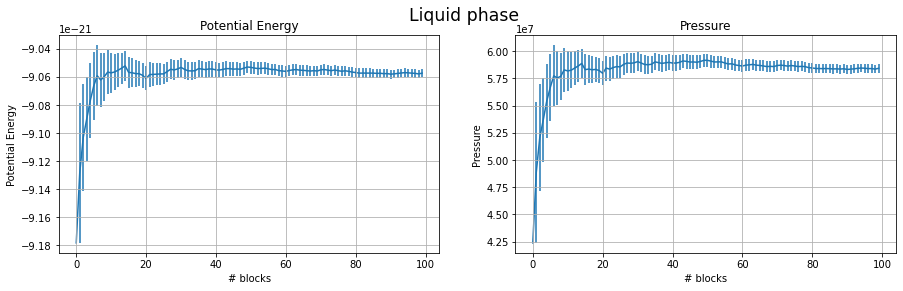

In [11]:
title = ["Potential Energy", "Pressure"]
x = np.arange(100)
plt.figure(figsize=(15,4))
plt.suptitle("Liquid phase", fontsize = "xx-large")
for i in range(2) :
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    y = block_method(data4_liquid_NVT[:,i]) * value[i]
    plt.errorbar(x, y[:,0], yerr = y[:,1], zorder = 0)
    plt.xlabel(r"# blocks")
    plt.ylabel(title[i])
    plt.grid(True)
plt.plot();

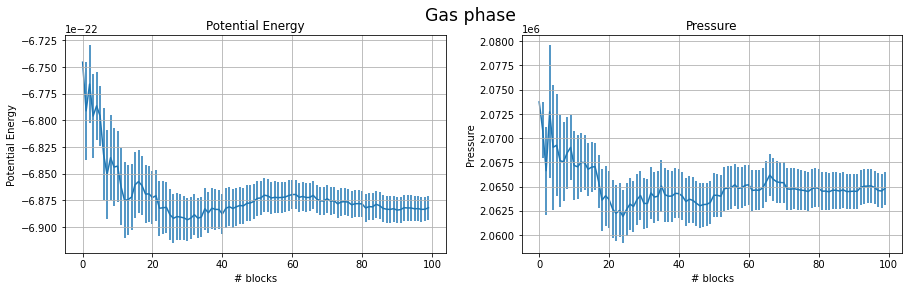

In [12]:
title = ["Potential Energy", "Pressure"]
x = np.arange(100)
plt.figure(figsize=(15,4))
plt.suptitle("Gas phase", fontsize = "xx-large")
for i in range(2) :
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    y = block_method(data4_gas_NVT[:,i]) * value[i]
    plt.errorbar(x, y[:,0], yerr = y[:,1], zorder = 0)
    plt.xlabel(r"# blocks")
    plt.ylabel(title[i])
    plt.grid(True)
plt.plot();

The plots suggest that it might be necessary to increment the number of throws per block in order to have better errorbars